Text(0.5,1,'undistorted/wrapped Image')

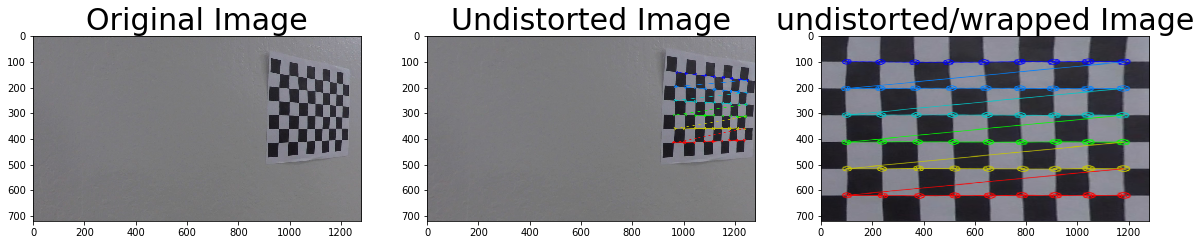

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import glob
%matplotlib inline

#first part of the rubric, chessboard files.


# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y


def calc_objimg_points(images,nx,ny):
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    return objpoints, imgpoints
    
    
def undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist =  cv2.undistort(img, mtx, dist, None, mtx)
    return undist


#Function from the course should work fine.:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img,nx, ny): #nx, ny, mtx, dist):
    # function as from the lesson, with small modification
    
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = img.shape[1::-1]

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(img, M, img_size)
    else: #could not find, so return 
        print("could not find corners, so returning orginal image")
        warped=img
        M=None
    # Return the resulting image and matrix
    return warped, M


#load multiple pictures to get distort data
images = glob.glob('camera_cal/*.jpg')
objpoints, imgpoints = calc_objimg_points(images,nx,ny)
image=cv2.imread(images[np.random.randint(len(images)-1)])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undist = undistort(image, objpoints, imgpoints)
unwrapedImage, m=  corners_unwarp(undist,nx, ny)

# Visualize undistortion
                               
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
ax3.imshow(unwrapedImage)
ax3.set_title('undistorted/wrapped Image', fontsize=30)

True

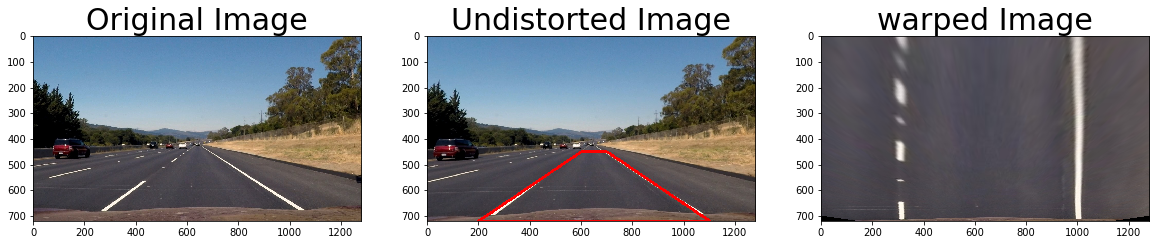

In [2]:
#second part
#Here we read the test image and apply the undist calculated in part 1.
#Then we draw some lines that will be used to wrap it.
def corners_unwarp_road(img,invert=False):
    src=np.float32([[200,720],[594,450],[686,450],[1080,720]])
    dst=np.float32([[300,720],[300,100],[980,100],[980,720]])
    #dst=np.float32([[400,720],[400,100],[880,100],[880,720]])
    if invert:
        M = cv2.getPerspectiveTransform(dst, src)
    else:
        M = cv2.getPerspectiveTransform(src, dst)
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = img.shape[1::-1]
    warped = cv2.warpPerspective(img, M, img_size)
    return warped
    
#images = glob.glob('test_images/*.jpg')
#images  = cv2.imread(images)#[np.random.randint(len(images)-1)])
#read all files and convert to rgb
images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in glob.glob('test_images/*.jpg')]
imageIndex=np.random.randint(len(images))
undist=np.zeros_like(images)
for i,image in enumerate(images):
    undist[i] = undistort(image, objpoints, imgpoints)



src=np.array([[200,720],[1100,720],[700,450],[600,450]], np.int32)
src = src.reshape((-1,1,2))
undist_line=cv2.polylines(undist[imageIndex].copy(), [src], True,(255,0,0),thickness=10)  
warped=corners_unwarp_road(undist[imageIndex])
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(images[imageIndex])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_line)
cv2.imwrite("undist.jpg",cv2.cvtColor(undist_line, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)
ax3.imshow(warped)
ax3.set_title('warped Image', fontsize=30)
cv2.imwrite("warp.jpg",cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

In [3]:
# Third part, use images above and apply sobel and some other stuff to
# create a binary image. we use an interact to play around and faster try new threshold values.
# Unfortunatly I don't have so much time left so cant try to many different.
# Another better method would be to use ml to come up with better values.

from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
from ipywidgets import widgets

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output
def test(ksize,xthresh_min,xthresh_max,ythresh_min,ythresh_max,magthresh_min,
         magthresh_max,dirthresh_min,dirthresh_max,s_thresh_min,s_thresh_max):

    images=undist
    for image in images:
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        gray = image[:,:,0]#cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)# keep only red

        # Apply each of the thresholding functions
        gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(xthresh_min, xthresh_max))
        grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(ythresh_min, ythresh_max))
        mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(magthresh_min, magthresh_max))
        dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(dirthresh_min, dirthresh_max))



        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
        gradyx = np.zeros_like(dir_binary)
        gradyx[((gradx == 1) & (grady == 1))] = 1
        magdir = np.zeros_like(dir_binary)
        magdir[(mag_binary == 1) & (dir_binary == 1)] = 1
        combined = np.zeros_like(dir_binary)
        combined[(gradyx ==1 ) | (magdir == 1) | (s_binary == 1)] = 1
        #combined = np.uint8(255*combined/np.max(combined))
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40,20))
        gradyx=corners_unwarp_road(gradyx.astype(np.uint8))
        ax1.imshow(gradyx, cmap='gray')
        ax1.set_title('x', fontsize=10)
        
        magdir=corners_unwarp_road(magdir.astype(np.uint8))
        ax2.imshow(magdir, cmap='gray')
        ax2.set_title('y', fontsize=10)
        
        s_binary=corners_unwarp_road(s_binary.astype(np.uint8))
        ax3.imshow(s_binary, cmap='gray')
        ax3.set_title('s', fontsize=10)


        combined=corners_unwarp_road(combined.astype(np.uint8))
        ax4.imshow(combined, cmap='gray')
        ax4.set_title('comb', fontsize=10)

    
    
    #gray = cv2.cvtColor(, cv2.COLOR_RGB2GRAY)#
    #sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    #abs_sobelx = np.absolute(sobelx)
    #scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #thresh_min = 20
    #thresh_max = 255
    #sxbinary = np.zeros_like(scaled_sobel)
    #sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #plt.imshow(sxbinary, cmap='gray'

interact_manual(test,ksize=widgets.IntSlider(min=1,max=31,step=2,value=9)
    ,xthresh_min=widgets.IntSlider(min=1,max=255,step=1,value=30)
    ,xthresh_max=widgets.IntSlider(min=1,max=255,step=1,value=230)
    ,ythresh_min=widgets.IntSlider(min=1,max=255,step=1,value=30)
    ,ythresh_max=widgets.IntSlider(min=1,max=255,step=1,value=230)
    ,magthresh_min=widgets.IntSlider(min=1,max=255,step=1,value=30)
    ,magthresh_max=widgets.IntSlider(min=1,max=255,step=1,value=150)
    ,dirthresh_min=widgets.FloatSlider(min=0,max=np.pi,step=np.pi/20,value=0.7)
    ,dirthresh_max=widgets.FloatSlider(min=0,max=np.pi,step=np.pi/20,value=1.3)
    ,s_thresh_min=widgets.IntSlider(min=1,max=255,step=1,value=80)
    ,s_thresh_max=widgets.IntSlider(min=1,max=255,step=1,value=255))

        #,ksize=widgets.IntSlider(min=1,max=255,step=1,value=1)
        #,ksize=widgets.IntSlider(min=1,max=255,step=1,value=1));
        
def test2(ksize,xthresh_min,xthresh_max,ythresh_min,ythresh_max):
    def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
        #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

        # Return the result
        return binary_output
    images=undist[0]
    gray = image[:,:,0]#cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)# keep only red

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(xthresh_min, xthresh_max))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(ythresh_min, ythresh_max))

    gradyx = np.zeros_like(grady)
    gradyx[((gradx == 1) & (grady == 1))] = 1
    #combined = np.uint8(255*combined/np.max(combined))
    f, (ax1) = plt.subplots(1, 1, figsize=(40,20))
    gradyx=corners_unwarp_road(gradyx.astype(np.uint8))
    ax1.imshow(gradyx, cmap='gray')
    ax1.set_title('x', fontsize=10)
    
interact_manual(test2,ksize=widgets.IntSlider(min=1,max=31,step=2,value=9)
    ,xthresh_min=widgets.IntSlider(min=1,max=255,step=1,value=30)
    ,xthresh_max=widgets.IntSlider(min=1,max=255,step=1,value=230)
    ,ythresh_min=widgets.IntSlider(min=1,max=255,step=1,value=30)
    ,ythresh_max=widgets.IntSlider(min=1,max=255,step=1,value=230));

#9,30,230,30,230,30,150,0.7,1.3,80,255

interactive(children=(IntSlider(value=9, description='ksize', max=31, min=1, step=2), IntSlider(value=30, description='xthresh_min', max=255, min=1), IntSlider(value=230, description='xthresh_max', max=255, min=1), IntSlider(value=30, description='ythresh_min', max=255, min=1), IntSlider(value=230, description='ythresh_max', max=255, min=1), IntSlider(value=30, description='magthresh_min', max=255, min=1), IntSlider(value=150, description='magthresh_max', max=255, min=1), FloatSlider(value=0.7, description='dirthresh_min', max=3.141592653589793, step=0.15707963267948966), FloatSlider(value=1.3, description='dirthresh_max', max=3.141592653589793, step=0.15707963267948966), IntSlider(value=80, description='s_thresh_min', max=255, min=1), IntSlider(value=255, description='s_thresh_max', max=255, min=1), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

interactive(children=(IntSlider(value=9, description='ksize', max=31, min=1, step=2), IntSlider(value=30, description='xthresh_min', max=255, min=1), IntSlider(value=230, description='xthresh_max', max=255, min=1), IntSlider(value=30, description='ythresh_min', max=255, min=1), IntSlider(value=230, description='ythresh_max', max=255, min=1), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

In [4]:
#part 3.5
#basicly same as above but witout interact:
def getBinaryWarp(image,ksize,xthresh_min,xthresh_max,ythresh_min,ythresh_max,magthresh_min,
         magthresh_max,dirthresh_min,dirthresh_max,s_thresh_min,s_thresh_max):

    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = image[:,:,0]#cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)# keep only red

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(xthresh_min, xthresh_max))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(ythresh_min, ythresh_max))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(magthresh_min, magthresh_max))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(dirthresh_min, dirthresh_max))



    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    gradyx = np.zeros_like(dir_binary)
    gradyx[((gradx == 1) & (grady == 1))] = 1
    
    magdir = np.zeros_like(dir_binary)
    magdir[(mag_binary == 1) & (dir_binary == 1)] = 1
    
    combined = np.zeros_like(dir_binary)
    combined[(gradyx ==1 ) | (magdir == 1) | (s_binary == 1)] = 1
    
    return corners_unwarp_road(combined.astype(np.uint8))

(720,)
235,648,475,720
248,567,488,639
242,505,482,577
231,435,471,507
217,386,457,458
202,320,442,392
178,224,418,296
127,187,367,259
108,130,348,202
73,17,313,89
[ -4.33079638e-04   7.14718016e-01   6.82107264e+01]
[ -4.33079638e-04   7.14718016e-01   7.94211064e+02]
(720,)


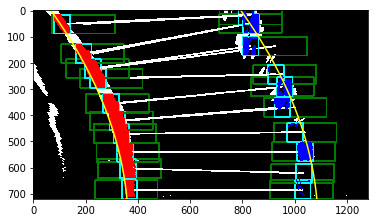

In [98]:
#part 4. find the lanes from the binary images
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image

#moved this here, maybe change place
ploty = np.linspace(0, images[0].shape[0]-1, images[0].shape[0] )
print(np.shape(ploty))
# Define conversions in x and y from pixels space to meters
ym_per_pix = 40/720. # meters per pixel in y dimension
xm_per_pix = 3.7/720. # meters per pixel in x dimension



def laneFinder(image):
    binary_warped = image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 120
    # Set minimum number of pixels found to recenter window
    minpix = 10
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    left_sum=0
    right_sum=0
    
    y_diff=0
    # Step through the windows one by one
    diffLOld=0
    diffROld=0
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        #win_y_low = binary_warped.shape[0] - ((window+1)*window_height)
        #win_y_high = binary_warped.shape[0] - (window*window_height)
        win_y_lowL = np.int(binary_warped.shape[0] - ((window+1)*window_height+y_diff))
        win_y_highL = np.int(binary_warped.shape[0] - (window*window_height+y_diff))
        win_y_low = np.int(binary_warped.shape[0] - ((window+1)*window_height-y_diff))
        win_y_high = np.int(binary_warped.shape[0] - (window*window_height-y_diff))
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        print(f"{win_xleft_low},{win_y_lowL},{win_xleft_high},{win_y_highL}")
        cv2.rectangle(out_img,(win_xleft_low,win_y_lowL),(win_xleft_high,win_y_highL),(0,123,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,123,0), 5) 
        pt1=((win_xleft_high+win_xleft_low)//2,(win_y_highL+win_y_lowL)//2)
        pt2=((win_xright_high+win_xright_low)//2,(win_y_high+win_y_low)//2)
        cv2.line(out_img,pt1,pt2,(255,255,255),5)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_lowL) & (nonzeroy < win_y_highL) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        #    left_lane_inds.append(good_left_inds)
        #    right_lane_inds.append(good_right_inds)   
        if False:
        # If you found > minpix pixels, recenter next window on their mean position
        
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        else:
            if len(good_left_inds) > minpix or len(good_right_inds) > minpix:
                if len(good_left_inds) > 0:
                    left_diff = np.int(np.mean(nonzerox[good_left_inds])) - leftx_current 
                else:
                    left_diff = 0

                if len(good_right_inds) > 0:
                    right_diff =  np.int(np.mean(nonzerox[good_right_inds])) - rightx_current
                else:
                    right_diff = 0

                y_diff=np.int((right_diff+left_diff)//2)
                #right_diff = rightx_current - np.int(np.mean(nonzerox[good_right_inds]))
                lr = len(good_left_inds)/(len(good_right_inds)+len(good_left_inds))
                #print(f"left:{len(good_left_inds)} r: {len(good_right_inds)} lr: {lr}")

                diffs = left_diff*lr + right_diff*(1-lr)
                #print(f"left:{left_diff} right: {right_diff} both: diffs {diffs}")
                
                #This should move so that pt2-pt1 is constant but maximize nonzerox for both sides
                diffROld=right_diff*1+diffROld*0
                diffLOld=left_diff*1+diffLOld*0
                leftx_current +=  np.int(diffLOld)#np.int(diffs)
                rightx_current += np.int(diffROld) #np.int(diffs)
            
            #only take middle after move
            win_xleft_low = leftx_current - margin//4
            win_xleft_high = leftx_current + margin//4
            win_xright_low = rightx_current - margin//4
            win_xright_high = rightx_current + margin//4
            good_left_inds = ((nonzeroy >= win_y_lowL) & (nonzeroy < win_y_highL) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            cv2.rectangle(out_img,(win_xleft_low,win_y_lowL),(win_xleft_high,win_y_highL),(0,255,255), 5) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,255), 5) 
            pt1=((win_xleft_high+win_xleft_low)//2,(win_y_highL+win_y_lowL)//2)
            pt2=((win_xright_high+win_xright_low)//2,(win_y_high+win_y_low)//2)
            cv2.line(out_img,pt1,pt2,(255,255,255),5)

            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)   
   
                


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit new polynomials to x,y in world space
    
    #ploty = np.linspace(0, 719, num=720)
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    
    
    tmp=(left_fit[0]+right_fit[0])/2
    left_fit[0]=tmp
    right_fit[0]=tmp
    
    tmp=(left_fit[1]+right_fit[1])/2
    left_fit[1]=tmp
    right_fit[1]=tmp
    
    tmp=(left_fit_cr[0]+right_fit_cr[0])/2
    left_fit_cr[0]=tmp
    right_fit_cr[0]=tmp
    
    tmp=(left_fit_cr[1]+right_fit_cr[1])/2
    left_fit_cr[1]=tmp
    right_fit_cr[1]=tmp
    return left_fit, right_fit, left_fit_cr ,right_fit_cr ,out_img

plt.imshow(out_img)
binary_warped=getBinaryWarp(images[imageIndex],9,30,230,30,230,30,150,0.7,1.3,80,255)
left_fit, right_fit,left_fit_cr ,right_fit_cr , out_img = laneFinder(binary_warped)

print(left_fit)
print(right_fit)

#both lines should be parrallel from above,
#also, diff in [2] should be about the same for all images (dist between lanes),
#so can use some sane filter using this.
#tmp=(left_fit[0]+right_fit[0])/2
#left_fit[0]=tmp
#right_fit[0]=tmp
#tmp=(left_fit[1]+right_fit[1])/2
#left_fit[1]=tmp
#right_fit[1]=tmp
plt.imshow(out_img)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
print(np.shape(ploty))
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]




plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)

(720,)


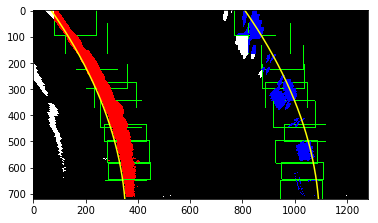

In [59]:
#part 4.5
#visualize 
# Generate x and y values for plotting
plt.imshow(out_img)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
print(np.shape(ploty))
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]




plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)

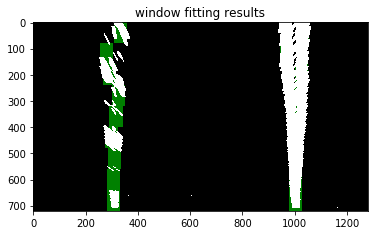

In [7]:

#import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Read in a thresholded image
warped = getBinaryWarp(images[imageIndex],9,30,230,30,230,30,150,0.7,1.3,110,255)
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


In [28]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.min(ploty)
left_curverad = (abs(1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = (abs(1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

# Example values: 1926.74 1908.48


yo = ym_per_pix#(image.shape[1]-1) * ym_per_pix

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

left_curverad = ((1 + (2*left_fit_cr[0]*yo + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*yo + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

2980.91389806 2057.82090787
602.336546303 m 371.75380621 m
602.326665822 m 371.74254263 m


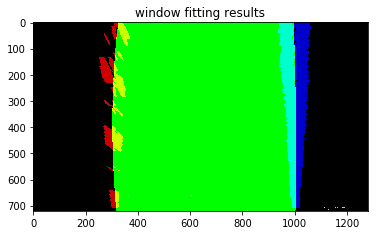

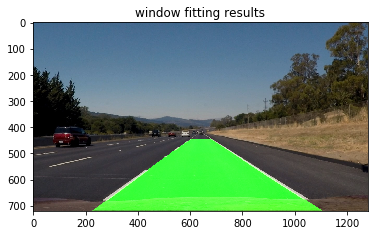

In [9]:
#calculate and draw when unwarped
filled_area=np.zeros_like(image).astype(np.uint8)
fitx_both=np.concatenate((np.transpose([left_fitx,ploty]),np.transpose([right_fitx[::-1],ploty[::-1]])))
cv2.fillPoly(filled_area,np.int_([fitx_both]),(0,255,0))
out_img2= cv2.addWeighted(filled_area,1,out_img,0.8,0)
plt.imshow(out_img2)
plt.title('window fitting results')
plt.show()
filled_area_unwarp = corners_unwarp_road(filled_area,True)
out_img2= cv2.addWeighted(filled_area_unwarp,1,images[imageIndex],0.8,0)
plt.imshow(out_img2)
plt.title('window fitting results')
plt.show()

In [44]:
def addFilledArea(image,left_fitx,right_fitx,ploty):
 
    filled_area=np.zeros_like(image).astype(np.uint8)
    fitx_both=np.concatenate((np.transpose([left_fitx,ploty]),np.transpose([right_fitx[::-1],ploty[::-1]])))
    cv2.fillPoly(filled_area,np.int_([fitx_both]),(0,255,0))
    
    filled_area_unwarp = corners_unwarp_road(filled_area,True)
   
    return cv2.addWeighted(filled_area_unwarp,1,image,0.8,0)

def addText(image,center_dist,left_curverad,right_curverad):
    cv2.putText(image, f"Curve Left: {left_curverad}",(50,100),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),2)
    cv2.putText(image, f"Curve Right: {right_curverad}",(50,150),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),2)
    cv2.putText(image, f"Center Distance: {center_dist}",(50,200),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),2)
    return image

259,648,499,720
215,605,455,677
223,490,463,562
258,415,498,487
283,340,523,412
312,263,552,335
350,182,590,254
398,111,638,183
445,25,685,97
487,-28,727,44


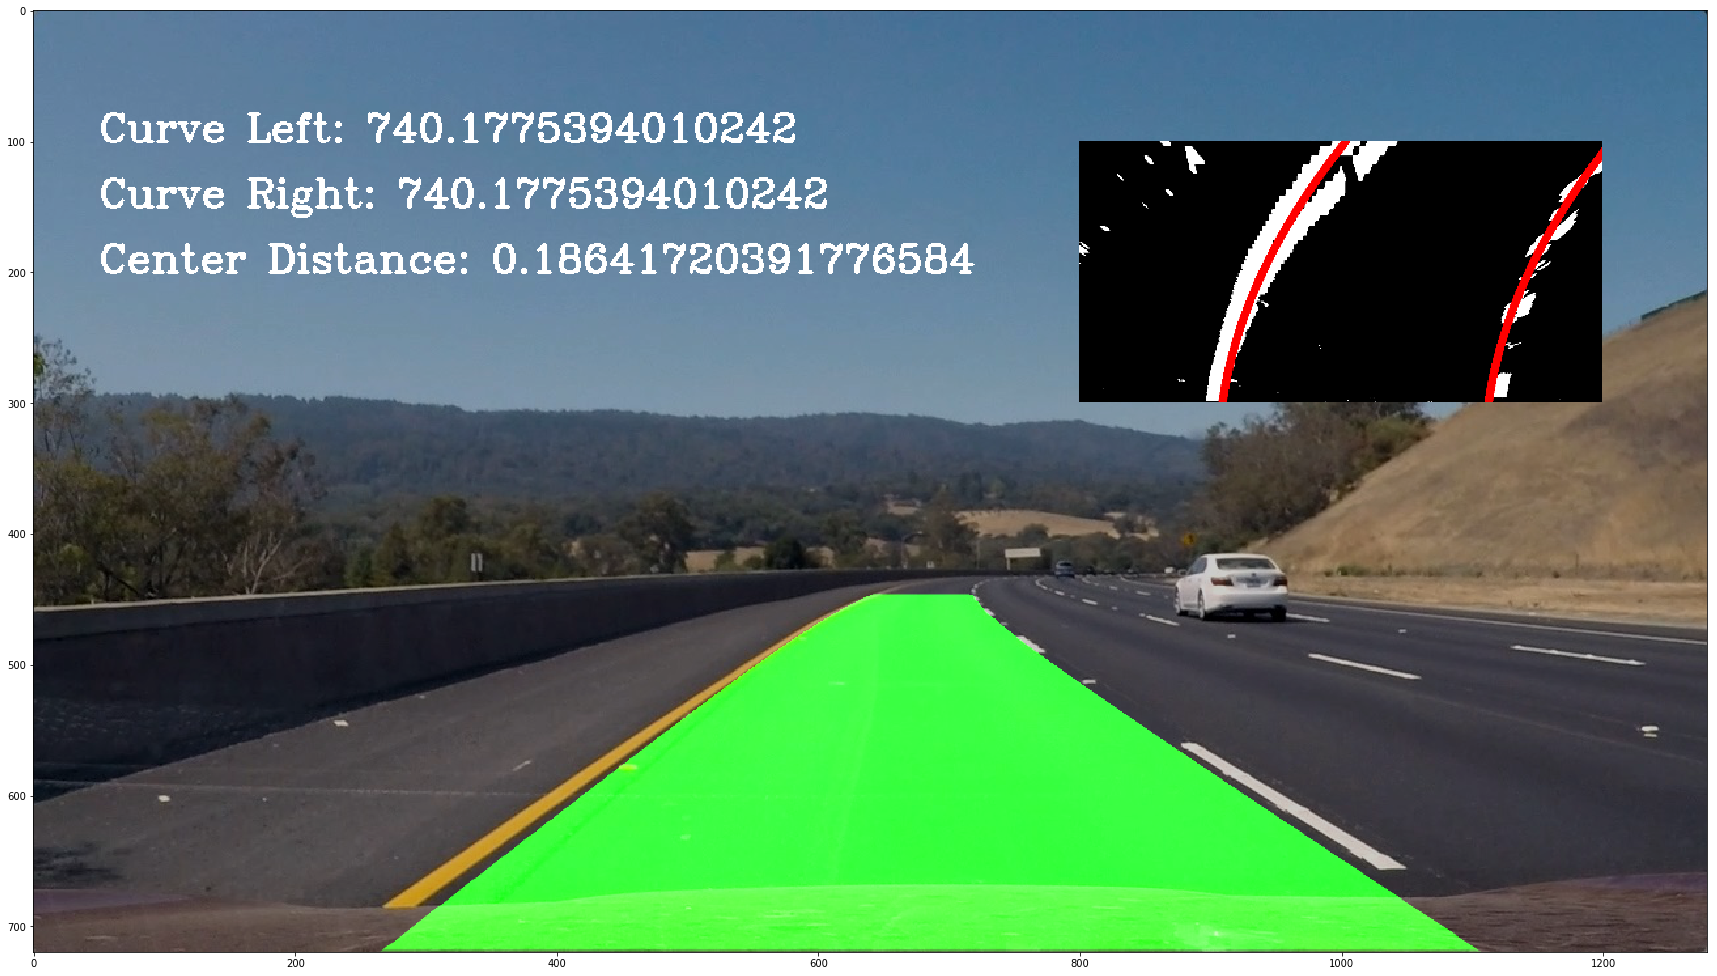

In [102]:
## Main pipline
# There's probably better ways so we can use variables as 
# arguments instead of globals
def process_image(input_image):
    image = undistort(input_image, objpoints, imgpoints)

    image = getBinaryWarp(image,9,30,230,30,230,30,150,0.7,1.3,110,255)
    binary_image=image.copy()
    left_fit, right_fit,left_fit_cr ,right_fit_cr, image = laneFinder(image) 

    
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    result_image = addFilledArea(input_image,left_fitx,right_fitx,ploty)
    

    y_eval = np.max(ploty)#
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1] )**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    center_dist=(left_fitx[-1]+right_fitx[-1])*xm_per_pix/2 - (out_img.shape[1]*xm_per_pix)/2 

    
    #add binarry in corner
    #https://stackoverflow.com/questions/14063070/overlay-a-smaller-image-on-a-larger-image-python-opencv
    x_offset=800
    y_offset=100
    

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    binary_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)*255 
    pts=np.int32(np.transpose(np.array([left_fitx,ploty])))
    pts2=np.int32(np.transpose(np.array([right_fitx,ploty])))
    binary_image=cv2.polylines(binary_image,[pts],False,(255,0,0),20)
    binary_image=cv2.polylines(binary_image,[pts2],False,(255,0,0),20)
    
    binary_image = cv2.resize(binary_image, (400,200))
    
    result_image = addText(result_image,center_dist,left_curverad,right_curverad)
    result_image[y_offset:y_offset+200, x_offset:x_offset+400] = binary_image
    
    
    return result_image

images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in glob.glob('test_images/*.jpg')]
imageIndex=np.random.randint(len(images)-1)

plt.figure(figsize = (30,30)) 
plt.imshow(process_image(images[imageIndex]))



In [12]:
np.int32(np.transpose(np.array([ploty,left_fitx])))

array([[  0, 325],
       [  1, 325],
       [  2, 325],
       ..., 
       [717, 319],
       [718, 319],
       [719, 319]], dtype=int32)

In [37]:
#main part
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'test_videos_output/project_video.mp4'

video_input = VideoFileClip("project_video.mp4").subclip(0,5)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
video = video_input.fl_image(process_image) #NOTE: this function expects color images!!
%time video.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video))

27.0321136515
min: 277.31435721084415, max: 277.31435721084415, mean: 277.31435721084415
[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


  1%|          | 1/126 [00:01<02:32,  1.22s/it]

27.0321136515
min: 277.31435721084415, max: 277.31435721084415, mean: 277.31435721084415


  2%|▏         | 2/126 [00:02<02:32,  1.23s/it]

28.0371381592
min: 289.3612525083913, max: 289.3612525083913, mean: 289.3612525083913


  2%|▏         | 3/126 [00:03<02:30,  1.22s/it]

27.7965916339
min: 293.16274097341466, max: 293.16274097341466, mean: 293.16274097341466


  3%|▎         | 4/126 [00:04<02:28,  1.22s/it]

28.3623771593
min: 305.05636305218684, max: 305.05636305218684, mean: 305.05636305218684


  4%|▍         | 5/126 [00:06<02:26,  1.21s/it]

28.5662975534
min: 321.3570501615427, max: 321.3570501615427, mean: 321.3570501615427


  5%|▍         | 6/126 [00:07<02:24,  1.20s/it]

28.2814966025
min: 325.4823743279294, max: 325.4823743279294, mean: 325.4823743279294


  6%|▌         | 7/126 [00:08<02:26,  1.23s/it]

26.9119238781
min: 324.34154766018804, max: 324.34154766018804, mean: 324.34154766018804


  6%|▋         | 8/126 [00:09<02:24,  1.22s/it]

25.6299441746
min: 319.9711465133708, max: 319.9711465133708, mean: 319.9711465133708


  7%|▋         | 9/126 [00:10<02:22,  1.21s/it]

25.4447332349
min: 336.89856912848626, max: 336.89856912848626, mean: 336.89856912848626


  8%|▊         | 10/126 [00:12<02:19,  1.20s/it]

23.0716411248
min: 329.9365974160558, max: 329.9365974160558, mean: 329.9365974160558


  9%|▊         | 11/126 [00:13<02:17,  1.20s/it]

22.6036064276
min: 332.18339425040375, max: 332.18339425040375, mean: 332.18339425040375


 10%|▉         | 12/126 [00:14<02:16,  1.19s/it]

21.1651729057
min: 345.8882477374107, max: 345.8882477374107, mean: 345.8882477374107


 10%|█         | 13/126 [00:15<02:14,  1.19s/it]

21.8252271584
min: 341.7547820434649, max: 341.7547820434649, mean: 341.7547820434649


 11%|█         | 14/126 [00:16<02:15,  1.21s/it]

20.0315529288
min: 327.6064929317764, max: 327.6064929317764, mean: 327.6064929317764


 12%|█▏        | 15/126 [00:18<02:15,  1.22s/it]

21.6261435831
min: 345.3655454423451, max: 345.3655454423451, mean: 345.3655454423451


 13%|█▎        | 16/126 [00:19<02:14,  1.22s/it]

20.9550378885
min: 337.64743184888584, max: 337.64743184888584, mean: 337.64743184888584


 13%|█▎        | 17/126 [00:20<02:11,  1.21s/it]

19.7276460739
min: 323.4147898424326, max: 323.4147898424326, mean: 323.4147898424326


 14%|█▍        | 18/126 [00:21<02:11,  1.22s/it]

17.8583429959
min: 308.98213420913413, max: 308.98213420913413, mean: 308.98213420913413


 15%|█▌        | 19/126 [00:23<02:11,  1.23s/it]

18.0772196749
min: 323.97447839181166, max: 323.97447839181166, mean: 323.97447839181166


 16%|█▌        | 20/126 [00:24<02:09,  1.22s/it]

18.9119345406
min: 343.2435253004801, max: 343.2435253004801, mean: 343.2435253004801


 17%|█▋        | 21/126 [00:25<02:08,  1.22s/it]

17.93666111
min: 345.73077051070277, max: 345.73077051070277, mean: 345.73077051070277


 17%|█▋        | 22/126 [00:26<02:05,  1.21s/it]

18.355296533
min: 369.9254422019206, max: 369.9254422019206, mean: 369.9254422019206


 18%|█▊        | 23/126 [00:27<02:04,  1.20s/it]

17.5270449838
min: 361.9455862881966, max: 361.9455862881966, mean: 361.9455862881966


 19%|█▉        | 24/126 [00:29<02:02,  1.20s/it]

14.7476424242
min: 311.46081562455646, max: 311.46081562455646, mean: 311.46081562455646


 20%|█▉        | 25/126 [00:30<02:00,  1.19s/it]

14.4535987877
min: 299.1430038845064, max: 299.1430038845064, mean: 299.1430038845064


 21%|██        | 26/126 [00:31<01:59,  1.20s/it]

17.0745535051
min: 318.85428469510833, max: 318.85428469510833, mean: 318.85428469510833


 21%|██▏       | 27/126 [00:32<02:00,  1.21s/it]

14.3585521361
min: 290.11692347619504, max: 290.11692347619504, mean: 290.11692347619504


 22%|██▏       | 28/126 [00:33<02:00,  1.23s/it]

14.4547986298
min: 296.3813801169369, max: 296.3813801169369, mean: 296.3813801169369


 23%|██▎       | 29/126 [00:35<01:57,  1.21s/it]

12.6487674829
min: 275.6403953392869, max: 275.6403953392869, mean: 275.6403953392869


 24%|██▍       | 30/126 [00:36<01:55,  1.20s/it]

12.9525844291
min: 272.63740841692817, max: 272.63740841692817, mean: 272.63740841692817


 25%|██▍       | 31/126 [00:37<01:53,  1.19s/it]

12.4892275351
min: 263.6007450253641, max: 263.6007450253641, mean: 263.6007450253641


 25%|██▌       | 32/126 [00:38<01:51,  1.19s/it]

10.5247029342
min: 242.02735785898176, max: 242.02735785898176, mean: 242.02735785898176


 26%|██▌       | 33/126 [00:39<01:52,  1.21s/it]

11.3918519626
min: 251.18862577730053, max: 251.18862577730053, mean: 251.18862577730053


 27%|██▋       | 34/126 [00:41<01:49,  1.20s/it]

9.55868613423
min: 241.6346932874183, max: 241.6346932874183, mean: 241.6346932874183


 28%|██▊       | 35/126 [00:42<01:47,  1.18s/it]

6.76845022736
min: 226.5861325264732, max: 226.5861325264732, mean: 226.5861325264732


 29%|██▊       | 36/126 [00:43<01:45,  1.18s/it]

6.14973130742
min: 224.02940893345243, max: 224.02940893345243, mean: 224.02940893345243


 29%|██▉       | 37/126 [00:44<01:44,  1.17s/it]

6.63654456377
min: 232.28675795810113, max: 232.28675795810113, mean: 232.28675795810113


 30%|███       | 38/126 [00:45<01:43,  1.17s/it]

-1.19393784869
min: 196.69293611103296, max: 196.69293611103296, mean: 196.69293611103296


 31%|███       | 39/126 [00:46<01:41,  1.17s/it]

3.87582142984
min: 222.34585321120647, max: 222.34585321120647, mean: 222.34585321120647


 32%|███▏      | 40/126 [00:48<01:40,  1.17s/it]

4.00353898984
min: 230.8071501985859, max: 230.8071501985859, mean: 230.8071501985859


 33%|███▎      | 41/126 [00:49<01:39,  1.17s/it]

4.52416148702
min: 238.79690083104873, max: 238.79690083104873, mean: 238.79690083104873


 33%|███▎      | 42/126 [00:50<01:38,  1.17s/it]

1.70232830774
min: 233.17747413579795, max: 233.17747413579795, mean: 233.17747413579795


 34%|███▍      | 43/126 [00:51<01:37,  1.17s/it]

2.99500611145
min: 248.16736897475198, max: 248.16736897475198, mean: 248.16736897475198


 35%|███▍      | 44/126 [00:52<01:36,  1.17s/it]

3.30465465558
min: 259.83610142382304, max: 259.83610142382304, mean: 259.83610142382304


 36%|███▌      | 45/126 [00:53<01:35,  1.18s/it]

3.85273691088
min: 269.2307065880133, max: 269.2307065880133, mean: 269.2307065880133


 37%|███▋      | 46/126 [00:55<01:34,  1.18s/it]

3.184900888
min: 264.2943474959846, max: 264.2943474959846, mean: 264.2943474959846


 37%|███▋      | 47/126 [00:56<01:32,  1.17s/it]

3.66175043601
min: 276.15046468891813, max: 276.15046468891813, mean: 276.15046468891813


 38%|███▊      | 48/126 [00:57<01:31,  1.18s/it]

3.65610859786
min: 284.5215659698885, max: 284.5215659698885, mean: 284.5215659698885


 39%|███▉      | 49/126 [00:58<01:30,  1.17s/it]

4.32067925751
min: 293.76847780823067, max: 293.76847780823067, mean: 293.76847780823067


 40%|███▉      | 50/126 [00:59<01:29,  1.18s/it]

3.16738564538
min: 296.1678784390195, max: 296.1678784390195, mean: 296.1678784390195


 40%|████      | 51/126 [01:00<01:28,  1.18s/it]

3.69738963094
min: 302.53150547718155, max: 302.53150547718155, mean: 302.53150547718155


 41%|████▏     | 52/126 [01:02<01:27,  1.18s/it]

4.00249457926
min: 287.48257365434023, max: 287.48257365434023, mean: 287.48257365434023


 42%|████▏     | 53/126 [01:03<01:26,  1.19s/it]

4.64771292661
min: 289.38897186174984, max: 289.38897186174984, mean: 289.38897186174984


 43%|████▎     | 54/126 [01:04<01:26,  1.20s/it]

6.28364685119
min: 303.7312184316633, max: 303.7312184316633, mean: 303.7312184316633


 44%|████▎     | 55/126 [01:05<01:25,  1.20s/it]

7.07026967378
min: 320.4062331041974, max: 320.4062331041974, mean: 320.4062331041974


 44%|████▍     | 56/126 [01:07<01:24,  1.21s/it]

7.94031434951
min: 328.86896690568574, max: 328.86896690568574, mean: 328.86896690568574


 45%|████▌     | 57/126 [01:08<01:24,  1.23s/it]

10.5687487602
min: 336.19614558516906, max: 336.19614558516906, mean: 336.19614558516906


 46%|████▌     | 58/126 [01:09<01:25,  1.26s/it]

10.2078666877
min: 338.56886035982586, max: 338.56886035982586, mean: 338.56886035982586


 47%|████▋     | 59/126 [01:10<01:23,  1.25s/it]

12.0050273664
min: 333.6180559973911, max: 333.6180559973911, mean: 333.6180559973911


 48%|████▊     | 60/126 [01:12<01:21,  1.24s/it]

14.6161049836
min: 337.28216866104543, max: 337.28216866104543, mean: 337.28216866104543


 48%|████▊     | 61/126 [01:13<01:20,  1.23s/it]

14.2739468606
min: 317.52794084692584, max: 317.52794084692584, mean: 317.52794084692584


 49%|████▉     | 62/126 [01:14<01:18,  1.22s/it]

17.2077833423
min: 303.63230030804345, max: 303.63230030804345, mean: 303.63230030804345


 50%|█████     | 63/126 [01:15<01:16,  1.22s/it]

18.6788098558
min: 307.9248406832593, max: 307.9248406832593, mean: 307.9248406832593


 51%|█████     | 64/126 [01:16<01:15,  1.22s/it]

15.304787945
min: 283.77111089549567, max: 283.77111089549567, mean: 283.77111089549567


 52%|█████▏    | 65/126 [01:18<01:14,  1.23s/it]

18.9115954616
min: 308.08163737711624, max: 308.08163737711624, mean: 308.08163737711624


 52%|█████▏    | 66/126 [01:19<01:13,  1.23s/it]

19.040594445
min: 298.5492139176365, max: 298.5492139176365, mean: 298.5492139176365


 53%|█████▎    | 67/126 [01:20<01:12,  1.22s/it]

20.8761341225
min: 321.1704070778759, max: 321.1704070778759, mean: 321.1704070778759


 54%|█████▍    | 68/126 [01:21<01:11,  1.23s/it]

21.4302322241
min: 327.9813365431427, max: 327.9813365431427, mean: 327.9813365431427


 55%|█████▍    | 69/126 [01:23<01:11,  1.25s/it]

21.8934753213
min: 323.41909220428045, max: 323.41909220428045, mean: 323.41909220428045


 56%|█████▌    | 70/126 [01:24<01:09,  1.24s/it]

22.3550692095
min: 339.0217129063233, max: 339.0217129063233, mean: 339.0217129063233


 56%|█████▋    | 71/126 [01:25<01:07,  1.23s/it]

22.3590800505
min: 333.2297128241584, max: 333.2297128241584, mean: 333.2297128241584


 57%|█████▋    | 72/126 [01:26<01:06,  1.24s/it]

22.6054017398
min: 344.258267776784, max: 344.258267776784, mean: 344.258267776784


 58%|█████▊    | 73/126 [01:28<01:05,  1.23s/it]

22.5512084812
min: 346.4206588483543, max: 346.4206588483543, mean: 346.4206588483543


 59%|█████▊    | 74/126 [01:29<01:03,  1.22s/it]

22.6868534936
min: 347.822369684351, max: 347.822369684351, mean: 347.822369684351


 60%|█████▉    | 75/126 [01:30<01:01,  1.21s/it]

22.3496523199
min: 359.7308648557694, max: 359.7308648557694, mean: 359.7308648557694


 60%|██████    | 76/126 [01:31<01:00,  1.22s/it]

23.1141722283
min: 350.49285113153877, max: 350.49285113153877, mean: 350.49285113153877


 61%|██████    | 77/126 [01:32<01:00,  1.23s/it]

22.8056785201
min: 361.9570154090771, max: 361.9570154090771, mean: 361.9570154090771


 62%|██████▏   | 78/126 [01:34<00:58,  1.23s/it]

21.4385283835
min: 360.2880499690411, max: 360.2880499690411, mean: 360.2880499690411


 63%|██████▎   | 79/126 [01:35<00:57,  1.23s/it]

21.2453797412
min: 359.88661238716185, max: 359.88661238716185, mean: 359.88661238716185


 63%|██████▎   | 80/126 [01:36<00:56,  1.23s/it]

21.2679458852
min: 351.2258591779388, max: 351.2258591779388, mean: 351.2258591779388


 64%|██████▍   | 81/126 [01:37<00:55,  1.23s/it]

22.0230225145
min: 342.2657957669643, max: 342.2657957669643, mean: 342.2657957669643


 65%|██████▌   | 82/126 [01:39<00:54,  1.23s/it]

21.3309144013
min: 333.4359465216394, max: 333.4359465216394, mean: 333.4359465216394


 66%|██████▌   | 83/126 [01:40<00:52,  1.23s/it]

20.6169974596
min: 319.35550267254206, max: 319.35550267254206, mean: 319.35550267254206


 67%|██████▋   | 84/126 [01:41<00:51,  1.23s/it]

20.1233780095
min: 338.2145912071423, max: 338.2145912071423, mean: 338.2145912071423


 67%|██████▋   | 85/126 [01:42<00:50,  1.23s/it]

19.3609651599
min: 323.48655098377367, max: 323.48655098377367, mean: 323.48655098377367


 68%|██████▊   | 86/126 [01:44<00:49,  1.23s/it]

19.7052364531
min: 321.28512518137507, max: 321.28512518137507, mean: 321.28512518137507


 69%|██████▉   | 87/126 [01:45<00:48,  1.25s/it]

21.3803525021
min: 295.8704910051528, max: 295.8704910051528, mean: 295.8704910051528


 70%|██████▉   | 88/126 [01:46<00:47,  1.24s/it]

22.8343695202
min: 288.5218186332519, max: 288.5218186332519, mean: 288.5218186332519


 71%|███████   | 89/126 [01:47<00:45,  1.24s/it]

22.9855791919
min: 269.66507682725415, max: 269.66507682725415, mean: 269.66507682725415


 71%|███████▏  | 90/126 [01:48<00:44,  1.24s/it]

21.2404475004
min: 244.45677599333396, max: 244.45677599333396, mean: 244.45677599333396


 72%|███████▏  | 91/126 [01:50<00:43,  1.24s/it]

21.405119261
min: 248.3162907556507, max: 248.3162907556507, mean: 248.3162907556507


 73%|███████▎  | 92/126 [01:51<00:42,  1.24s/it]

21.0930260314
min: 247.30819782447793, max: 247.30819782447793, mean: 247.30819782447793


 74%|███████▍  | 93/126 [01:52<00:40,  1.24s/it]

19.8856709008
min: 240.9485072217116, max: 240.9485072217116, mean: 240.9485072217116


 75%|███████▍  | 94/126 [01:53<00:39,  1.24s/it]

21.4049623459
min: 248.88738358130436, max: 248.88738358130436, mean: 248.88738358130436


 75%|███████▌  | 95/126 [01:55<00:38,  1.24s/it]

21.0684107261
min: 255.46925451547554, max: 255.46925451547554, mean: 255.46925451547554


 76%|███████▌  | 96/126 [01:56<00:37,  1.23s/it]

21.4129698695
min: 262.5936814179586, max: 262.5936814179586, mean: 262.5936814179586


 77%|███████▋  | 97/126 [01:57<00:35,  1.24s/it]

21.2162316293
min: 261.0998247165592, max: 261.0998247165592, mean: 261.0998247165592


 78%|███████▊  | 98/126 [01:58<00:34,  1.23s/it]

21.715007095
min: 273.01257645927507, max: 273.01257645927507, mean: 273.01257645927507


 79%|███████▊  | 99/126 [02:00<00:33,  1.23s/it]

19.7595957408
min: 254.22967716507003, max: 254.22967716507003, mean: 254.22967716507003


 79%|███████▉  | 100/126 [02:01<00:31,  1.23s/it]

20.6422793614
min: 264.74326260543995, max: 264.74326260543995, mean: 264.74326260543995


 80%|████████  | 101/126 [02:02<00:30,  1.23s/it]

19.7928669084
min: 261.53842933616374, max: 261.53842933616374, mean: 261.53842933616374


 81%|████████  | 102/126 [02:03<00:29,  1.23s/it]

19.2834487387
min: 250.5171765693221, max: 250.5171765693221, mean: 250.5171765693221


 82%|████████▏ | 103/126 [02:05<00:28,  1.24s/it]

18.9148599105
min: 249.0350381940858, max: 249.0350381940858, mean: 249.0350381940858


 83%|████████▎ | 104/126 [02:06<00:27,  1.26s/it]

18.8761372916
min: 246.30444322592868, max: 246.30444322592868, mean: 246.30444322592868


 83%|████████▎ | 105/126 [02:07<00:26,  1.25s/it]

19.6806811062
min: 260.43070102586364, max: 260.43070102586364, mean: 260.43070102586364


 84%|████████▍ | 106/126 [02:08<00:25,  1.26s/it]

21.0470434563
min: 277.7483948105597, max: 277.7483948105597, mean: 277.7483948105597


 85%|████████▍ | 107/126 [02:10<00:24,  1.28s/it]

20.6974348272
min: 281.3226522031023, max: 281.3226522031023, mean: 281.3226522031023


 86%|████████▌ | 108/126 [02:11<00:22,  1.27s/it]

20.2273497845
min: 266.043744256995, max: 266.043744256995, mean: 266.043744256995


 87%|████████▋ | 109/126 [02:12<00:21,  1.26s/it]

20.0976712917
min: 266.90769515325593, max: 266.90769515325593, mean: 266.90769515325593


 87%|████████▋ | 110/126 [02:13<00:20,  1.26s/it]

20.0679324164
min: 266.0085640426791, max: 266.0085640426791, mean: 266.0085640426791


 88%|████████▊ | 111/126 [02:15<00:18,  1.26s/it]

19.8966947738
min: 265.744719412053, max: 265.744719412053, mean: 265.744719412053


 89%|████████▉ | 112/126 [02:17<00:20,  1.45s/it]

19.4143409113
min: 268.3822327402435, max: 268.3822327402435, mean: 268.3822327402435


 90%|████████▉ | 113/126 [02:18<00:18,  1.41s/it]

19.4751994963
min: 262.8035869249538, max: 262.8035869249538, mean: 262.8035869249538


 90%|█████████ | 114/126 [02:19<00:16,  1.35s/it]

20.2612858502
min: 263.05149458405, max: 263.05149458405, mean: 263.05149458405


 91%|█████████▏| 115/126 [02:20<00:14,  1.32s/it]

19.8287715856
min: 251.7699628998379, max: 251.7699628998379, mean: 251.7699628998379


 92%|█████████▏| 116/126 [02:22<00:13,  1.32s/it]

18.1484293842
min: 248.55027470608383, max: 248.55027470608383, mean: 248.55027470608383


 93%|█████████▎| 117/126 [02:23<00:12,  1.34s/it]

18.1401315637
min: 252.7971650193316, max: 252.7971650193316, mean: 252.7971650193316


 94%|█████████▎| 118/126 [02:25<00:11,  1.49s/it]

17.6268717238
min: 253.18235242308396, max: 253.18235242308396, mean: 253.18235242308396


 94%|█████████▍| 119/126 [02:26<00:09,  1.41s/it]

17.7876128321
min: 258.9125324684442, max: 258.9125324684442, mean: 258.9125324684442


 95%|█████████▌| 120/126 [02:27<00:08,  1.36s/it]

16.7123864538
min: 248.34805353513025, max: 248.34805353513025, mean: 248.34805353513025


 96%|█████████▌| 121/126 [02:29<00:06,  1.33s/it]

17.0309820055
min: 251.07854197289498, max: 251.07854197289498, mean: 251.07854197289498


 97%|█████████▋| 122/126 [02:30<00:05,  1.33s/it]

16.9944179778
min: 252.43199045257734, max: 252.43199045257734, mean: 252.43199045257734


 98%|█████████▊| 123/126 [02:32<00:04,  1.51s/it]

16.630657031
min: 248.8024016789814, max: 248.8024016789814, mean: 248.8024016789814


 98%|█████████▊| 124/126 [02:34<00:03,  1.55s/it]

16.5747916611
min: 252.34203989206986, max: 252.34203989206986, mean: 252.34203989206986


 99%|█████████▉| 125/126 [02:35<00:01,  1.45s/it]

18.0247133571
min: 251.07762290790976, max: 251.07762290790976, mean: 251.07762290790976


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 2min 37s, sys: 464 ms, total: 2min 38s
Wall time: 2min 36s
